Submitted by: Vikas Gola (2016UCS0023) and Sahil Bansal (2016UCS0008)

- Change the **base_path** variable to the current directory where the **dataset/** folder is present.

# Import libraries

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
# with open('/content/gdrive/My Drive/Colab Notebooks/dataset/hello.txt', 'w') as f:
#   f.write('Hello Google Drive!')
# !cat /content/gdrive/My\ Drive/Colab\ Notebooks/dataset/hello.txt

In [0]:
import glob
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as path

# Read the images

In [0]:
# get the image id from the image path
img = "/content/gdrive/My Drive/Colab Notebooks/dataset/1.png"
path.splitext(path.basename(img))[0]

'1'

In [0]:
base_path = "/content/gdrive/My Drive/Colab Notebooks/"

In [0]:
imgs = []
imgids = []
for img in glob.glob(base_path + "dataset/*.png"):
    # get the image id
    imgids.append(int(path.splitext(path.basename(img))[0]))
    # read the image
    input_img = cv2.imread(img, 0)
    # add to the imgs list
    imgs.append(input_img)

In [0]:
# zip and sort the imgids and imgs by the image_id
imgids, imgs = zip(*sorted(zip(imgids, imgs)))
# create np arrays
imgs = np.array(imgs)
imgids = np.array(imgids)
# print the shapes
print(imgids.shape)
print(imgs.shape)

(84,)
(84, 768, 1024)


Thus, the size of an image is 768x1024 and there are total 84 images.

# Read the subjective scores

In [0]:
subjective_scores = np.array(pd.read_excel(base_path + "dataset/DMOS_DIBR.xlsx", index_col = None, header = None))[:, 0]
print(subjective_scores.shape)

(84,)


In [0]:
# create a numpy array to store the objective scores
objective_scores = np.zeros(subjective_scores.shape)
print(objective_scores.shape)

(84,)


# Images with really poor Subjective scores

In [0]:
# for i in range(subjective_scores.shape[0]):
#     print(i + 1, subjective_scores[i])

# image 1

print("Images with really poor Subjective Scores are: ")
worst = 5
no = -1
for i in range(0, 28):
    if (subjective_scores[i] < worst):
        worst = subjective_scores[i]
        no = i + 1
print(no, worst)

# image 2
worst = 5
for i in range(28, 56):
    if (subjective_scores[i] < worst):
        worst = subjective_scores[i]
        no = i + 1
print(no, worst)

# image 3
worst = 5
for i in range(56, 84):
    if (subjective_scores[i] < worst):
        worst = subjective_scores[i]
        no = i + 1
print(no, worst)

Images with really poor Subjective Scores are: 
3 1.720930233
38 2.581395349
80 1.88372093


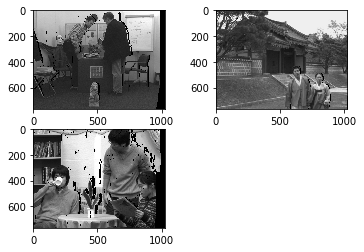

In [0]:
fig = plt.figure()
fig.add_subplot(2, 2, 1)
plt.imshow(imgs[2], cmap = 'gray')
fig.add_subplot(2, 2, 2)
plt.imshow(imgs[37], cmap = 'gray')
fig.add_subplot(2, 2, 3)
plt.imshow(imgs[79], cmap = 'gray')

# Image Quality Assessment - Morphological Hole Filling

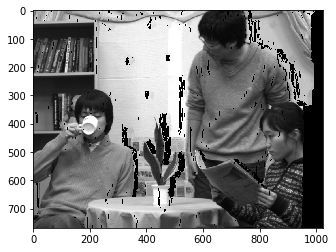

In [0]:
plt.imshow(imgs[79], cmap='gray')

In [0]:
im_in = imgs[79]
th, im_th = cv2.threshold(im_in, 11, 255, cv2.THRESH_BINARY_INV);

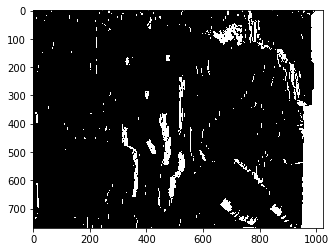

In [0]:
plt.imshow(im_th, cmap='gray')

In [0]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
res = cv2.morphologyEx(im_th,cv2.MORPH_OPEN,kernel)

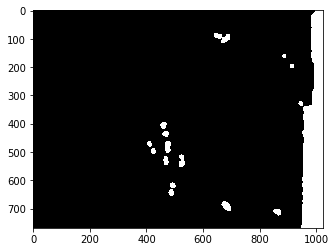

In [0]:
plt.imshow(res, cmap='gray')

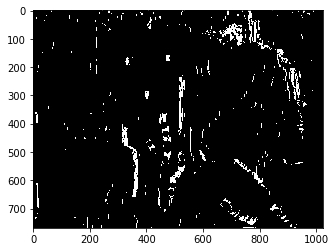

In [0]:
plt.imshow(res - im_th, cmap='gray')

In [0]:
diff = res - im_th
np.mean(diff)

0.04039764404296875

# IQA Algorithm - Final

In [0]:
best = 0
for k in range(0, 255):
    for i in range(imgs.shape[0]):
        im_in = imgs[i]
        # binary inverse threshold, make all pixels above 'k' to be zero
        th, im_th = cv2.threshold(im_in, k, 255, cv2.THRESH_BINARY_INV);
        # kernel for morpholical opening
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
        # perform opening
        res = cv2.morphologyEx(im_th,cv2.MORPH_OPEN,kernel)
        # difference between resulting image and threshold, will have 1 where black patch
        diff = res - im_th
        # take the mean to be the objective score
        objective_scores[i] = np.mean(diff)
    plcc = np.corrcoef(subjective_scores, objective_scores)[0, 1]
    if (abs(plcc) > best):
        best = abs(plcc)
        print("Current best: ", k, best)
    else:
        print("Current: ", k, abs(plcc))

Current best:  0 0.5631338288902227
Current best:  1 0.5637520536992858


KeyboardInterrupt: ignored

In [326]:
threshold = 11
for i in range(imgs.shape[0]):
    im_in = imgs[i]
    th, im_th = cv2.threshold(im_in, 11, 255, cv2.THRESH_BINARY_INV);
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
    res = cv2.morphologyEx(im_th,cv2.MORPH_OPEN,kernel)
    diff = res - im_th
    objective_scores[i] = np.mean(diff)
plcc = abs(np.corrcoef(subjective_scores, objective_scores)[0, 1])
print("PLCC: ", plcc)

PLCC:  0.6292921895548697


# IQA Algorithm (Median Filter)

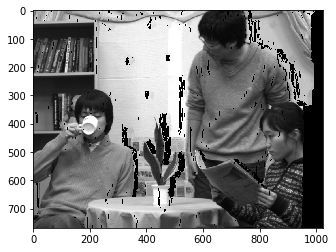

In [355]:
img_in = imgs[79]
plt.imshow(img_in, cmap = 'gray')

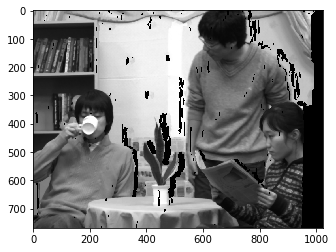

In [356]:
img_filtered = cv2.medianBlur(img_in, 5)
plt.imshow(img_filtered, cmap = 'gray')

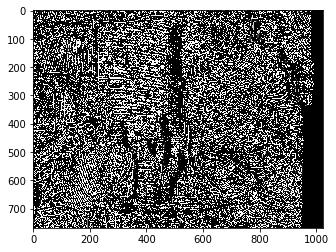

In [357]:
img_out = abs(img_in - img_filtered)
plt.imshow(img_out, cmap = 'gray')

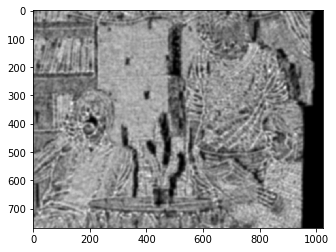

In [358]:
kernel = np.ones((3, 3), np.float32)/9
img_out_smooth = cv2.filter2D(img_out, -1, kernel)
for i in range(20):
    img_out_smooth = cv2.filter2D(img_out_smooth, -1, kernel)
plt.imshow(img_out_smooth, cmap = 'gray')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5872c67400>,
 Text(0.5, 1.0, 'Threshold 2'))

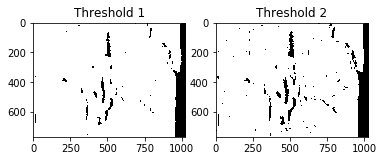

In [359]:
t1 = 25
t2 = 35
ret, thresh1 = cv2.threshold(img_out_smooth, t1, 255, cv2.THRESH_BINARY)
plt.subplot(121), plt.imshow(thresh1, cmap = 'gray'), plt.title('Threshold 1')
ret, thresh2 = cv2.threshold(img_out_smooth, t2, 255, cv2.THRESH_BINARY)
plt.subplot(122), plt.imshow(thresh2, cmap = 'gray'), plt.title('Threshold 2')

In [360]:
mean = np.std(thresh1)
print(mean)

67.72896351949971


In [361]:
t1 = 25
t2 = 35
for i in range(imgs.shape[0]):
    img_in = imgs[i]
    img_filtered = cv2.medianBlur(img_in, 5)
    img_out = abs(img_in - img_filtered)
    kernel = np.ones((3, 3), np.float32)/9
    img_out_smooth = cv2.filter2D(img_out, -1, kernel)
    for i in range(10):
        img_out_smooth = cv2.filter2D(img_out_smooth, -1, kernel)
    ret, thresh1 = cv2.threshold(img_out_smooth, t1, 255, cv2.THRESH_BINARY)
    ret, thresh2 = cv2.threshold(img_out_smooth, t2, 255, cv2.THRESH_BINARY)
    std1 = np.std(thresh1)
    std2 = np.std(thresh2)
    objective_scores[i] = (2*std1*std2)/(std1**2 + std2**2)
plcc = abs(np.corrcoef(subjective_scores, objective_scores)[0, 1])
print(plcc)

0.21545504240303606


## Considering multiple objective scores for an image

In [362]:
mean1, std1 = cv2.meanStdDev(thresh1)
mean2, std2 = cv2.meanStdDev(thresh2)
mean1 = mean1[0, 0]
mean2 = mean2[0, 0]
std1 = std1[0, 0]
std2 = std2[0, 0]
print(mean1, std1)
print(mean2, std2)

246.95440292358398 44.574607369780054
240.63543319702148 58.79305873419318


In [363]:
eps = 0.001
scores = np.zeros((5,))
scores[0] = std1 + std2
scores[1] = std1 * std2
scores[2] = (std1*std2 + eps)/(std1**2 + eps)
scores[3] = (std1*std2 + eps)/(std2**2 + eps)
scores[4] = (2*std1*std2 + eps)/(std1**2 + std2**2 + eps)
print(scores)

[1.03367666e+02 2.62067751e+03 1.31898081e+00 7.58161124e-01
 9.62861467e-01]
